I annotated the Bone Atlas by first aggregating all published annotations from the constituent datasets. Published labels were available for 604,282 of 1,566,868 cells; the remaining cells were treated as query cells.

To infer labels for query cells, I performed nearest-neighbour transfer in a shared latent space. The latent space was selected via an SCVI integration parameter sweep, and the best embedding was chosen using scIB metrics (see Integration). 


On this embedding I ran two label-propagation implementations:

(i) a GPU-accelerated FAISS search (“GPU method”) and 

(ii) a conventional k-nearest neighbours search (“kNN method”).

For each query cell, a Level-3 (fine-grained) label was assigned by distance-weighted majority vote among its k nearest reference cells (those with published labels). Resulting label series were aligned to the atlas by stable Cell_ID and written into both AnnData objects (full-gene and HVG) as propagated_anno_gpu and propagated_anno_knn. For multi-resolution analyses, Level-3 labels were mapped to Level-2 (family) and Level-1 (lineage) using a curated lookup table that I created (levels_df, columns Level1/Level2/Level3), harmonising synonyms across datasets and standardising lineage definitions; these mappings were stored as propagated_anno{gpu/cpu}_level2 and propagated_anno{gpu/cpu}_level1.


All new columns were stored as pandas categoricals (for reproducible plotting and memory efficiency), and alignment was enforced by obs_names/Cell_ID to avoid index drift. Concordance between methods was quantified on shared cells using exact-match rate and inspected with row-normalised confusion matrices to distinguish within-lineage from cross-lineage discrepancies. For visual validation, I generated dot plots of canonical marker panels ordered by biological hierarchy, excluding non-target tissues and QC bins where relevant. To minimise I/O risk, I exported only the obs tables (including the new annotations) to Parquet for later re-attachment, and avoided re-writing the full AnnData objects.

In [1]:
import scanpy as sc
import pandas as pd
adata_full= sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_best_embedding_with_all_genes_log_normalised.h5ad') 
adata= sc.read_h5ad('/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_best_embedding_with_hvg_only.h5ad') 

In [2]:
import sys
import pyarrow
sys.path.append("/nfs/team298/sm54/BoneAtlasProject/annotation")
from helper_functions import save_obs


In [3]:
adata_full

AnnData object with n_obs × n_vars = 1566868 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pre

In [6]:
1566868-962586

604282

In [5]:
# Labels & mapping
gpu_csv = "/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/bone_atlas_propagated_labels_gpu_faiss.csv"
knn_csv = "/lustre/scratch124/cellgen/haniffa/users/sm54/data/Bone_Atlas/boneatlas_propagated_labels_knn.csv"
levels_csv = "/nfs/team298/sm54/BoneAtlasProject/metadata/old_annotations/published_anno_bone_atlas_levels_123.csv"  # Level1/2/3


# --- 1) Load label tables & level mapping -------------------------------------
# GPU labels (index: Cell_ID or obs_names; column: propagated_anno or single col)
gpu_df = pd.read_csv(gpu_csv, index_col=0)
gpu_label_col = "propagated_anno" if "propagated_anno" in gpu_df.columns else gpu_df.columns[0]
gpu_series = gpu_df[gpu_label_col].astype(str).str.strip()



In [5]:
gpu_df

,propagated_anno
CGCAATGTCAGCAAGA-HCA_BN_F12482363,Erythroid
TAATCACCAATTGACT-HCA_BN_F12482363,ERYTHROCYTE
CAAGTAACATGACTAT-HCA_BN_F12482363,Epithelial
AAAGCCGCATGTTGCA-HCA_BN_F12482363,Erythroid
TGGCGGTTCTCCTCAA-HCA_BN_F12482363,low_confidence
...,...
ACCCACTCATCGATGT-5478STDY7850149,PAX7+MyoProg
ACTTACTTCCTGTACC-5478STDY7850149,TENDON_PROGENITOR
CTCTAATCAAGTAATG-5478STDY7850149,ProlifChon
AGAGCGACACATCCGG-5478STDY7850149,Preosteoblast


In [7]:
gpu_series

CGCAATGTCAGCAAGA-HCA_BN_F12482363            Erythroid
TAATCACCAATTGACT-HCA_BN_F12482363          ERYTHROCYTE
CAAGTAACATGACTAT-HCA_BN_F12482363           Epithelial
AAAGCCGCATGTTGCA-HCA_BN_F12482363            Erythroid
TGGCGGTTCTCCTCAA-HCA_BN_F12482363       low_confidence
                                           ...        
ACCCACTCATCGATGT-5478STDY7850149          PAX7+MyoProg
ACTTACTTCCTGTACC-5478STDY7850149     TENDON_PROGENITOR
CTCTAATCAAGTAATG-5478STDY7850149            ProlifChon
AGAGCGACACATCCGG-5478STDY7850149         Preosteoblast
GACCTGGCATACAGCT-5478STDY7850149        low_confidence
Name: propagated_anno, Length: 962586, dtype: object

In [8]:
# kNN labels (same structure)
knn_df = pd.read_csv(knn_csv, index_col=0)
knn_label_col = "propagated_anno" if "propagated_anno" in knn_df.columns else knn_df.columns[0]
knn_series = knn_df[knn_label_col].astype(str).str.strip()


In [9]:
knn_series

CGCAATGTCAGCAAGA-HCA_BN_F12482363            Erythroid
TAATCACCAATTGACT-HCA_BN_F12482363          ERYTHROCYTE
CAAGTAACATGACTAT-HCA_BN_F12482363           Epithelial
AAAGCCGCATGTTGCA-HCA_BN_F12482363            Erythroid
TGGCGGTTCTCCTCAA-HCA_BN_F12482363       low_confidence
                                           ...        
ACCCACTCATCGATGT-5478STDY7850149          PAX7+MyoProg
ACTTACTTCCTGTACC-5478STDY7850149     TENDON_PROGENITOR
CTCTAATCAAGTAATG-5478STDY7850149            ProlifChon
AGAGCGACACATCCGG-5478STDY7850149         Preosteoblast
GACCTGGCATACAGCT-5478STDY7850149        low_confidence
Name: propagated_anno, Length: 962586, dtype: object

In [10]:
# Level mapping
levels_df = pd.read_csv(levels_csv)
required_cols = {"Level1", "Level2", "Level3"}
missing = required_cols.difference(levels_df.columns)
if missing:
    raise KeyError(f"levels_df is missing columns: {missing}")

levels_df = levels_df.copy()
for c in ["Level1", "Level2", "Level3"]:
    levels_df[c] = levels_df[c].astype(str).str.strip()


In [11]:
levels_df

,Level1,Level2,Level3
0,Erythroid,Erythroid,erythroid macrophage
1,Haematopoietic,Myeloid,neutrophil
2,Haematopoietic,Myeloid,CD14 monocyte
3,Haematopoietic,Progenitor,DC precursor
4,Haematopoietic,Progenitor,ELP
...,...,...,...
329,Haematopoietic,Haematopoietic,DOUBLET_IMMUNE_FIBROBLAST
330,Haematopoietic,Progenitor,CYCLING_MEMP
331,Haematopoietic,Lymphoid,PLASMA_B
332,Haematopoietic,Lymphoid,DN(P)_T


In [12]:
# Deduplicate by Level3 (keep first occurrence)
if levels_df["Level3"].duplicated(keep="first").any():
    dups = levels_df.loc[levels_df["Level3"].duplicated(keep="first"), "Level3"].unique()
    print(f"[warn] Duplicate Level3 in mapping; keeping first for: {dups[:10]}{' ...' if len(dups)>10 else ''}")
    levels_df = levels_df.drop_duplicates(subset="Level3", keep="first")

lvl3_to_lvl2 = levels_df.set_index("Level3")["Level2"].to_dict()
lvl3_to_lvl1 = levels_df.set_index("Level3")["Level1"].to_dict()



In [13]:
# --- 2) Helper: attach Level3 labels + map to Level2/1, by Cell_ID if present -
def add_prefixed_labels(
    adata_obj: "AnnData",
    lvl3_series: pd.Series,
    prefix: str,
    fallback_col: str = "published_anno",
    key_col: str = "Cell_ID",
    verbose: bool = True,
):
    """
    Creates three columns in .obs (values are plain labels; prefix only affects the column names):
      - propagated_anno_{prefix}          (Level3)
      - propagated_anno_{prefix}_level2   (mapped from Level3; fallback to Level3 if unmapped)
      - propagated_anno_{prefix}_level1   (mapped from Level3; fallback to Level3 if unmapped)

    Alignment:
      - If `key_col` exists in adata.obs, map by that (recommended: 'Cell_ID').
      - Else, align by obs_names ∩ lvl3_series.index.

    Fallback:
      - Where no label is provided in lvl3_series, falls back to `fallback_col`.
    """
    # Ensure fallback is available
    if fallback_col not in adata_obj.obs:
        raise KeyError(f"'{fallback_col}' not found in adata.obs. Please provide a valid fallback_col.")

    base = adata_obj.obs[fallback_col].astype(str).str.strip()

    # Prefer mapping by Cell_ID (or user-specified key)
    if key_col in adata_obj.obs:
        # Ensure key as string
        key_vals = adata_obj.obs[key_col].astype(str)
        mapped = key_vals.map(lvl3_series.astype(str))  # may produce NaN where missing
        lvl3 = base.where(mapped.isna(), mapped).astype(str)
        n_attached = mapped.notna().sum()
    else:
        # Fallback to obs_names alignment
        idx = adata_obj.obs.index.intersection(lvl3_series.index)
        lvl3 = base.copy()
        lvl3.loc[idx] = lvl3_series.loc[idx]
        n_attached = idx.size
        if verbose:
            print(f"[info] '{key_col}' not found; aligned by obs_names.")

    # Write columns (as Categoricals for stability/memory)
    adata_obj.obs[f"propagated_anno_{prefix}"] = pd.Categorical(lvl3)
    adata_obj.obs[f"propagated_anno_{prefix}_level2"] = pd.Categorical(lvl3.map(lvl3_to_lvl2).fillna(lvl3))
    adata_obj.obs[f"propagated_anno_{prefix}_level1"] = pd.Categorical(lvl3.map(lvl3_to_lvl1).fillna(lvl3))

    if verbose:
        print(f"[{prefix}] attached to {n_attached:,} cells out of {adata_obj.n_obs:,} in this AnnData.")


In [14]:
# --- 3) Attach GPU and kNN labels to BOTH adata and adata_full -----------------
# GPU → prefix='gpu'
add_prefixed_labels(adata,      gpu_series, prefix="gpu", fallback_col="published_anno", key_col="Cell_ID", verbose=True)
add_prefixed_labels(adata_full, gpu_series, prefix="gpu", fallback_col="published_anno", key_col="Cell_ID", verbose=True)


[gpu] attached to 962,586 cells out of 1,566,868 in this AnnData.
[gpu] attached to 962,586 cells out of 1,566,868 in this AnnData.


In [15]:
adata

AnnData object with n_obs × n_vars = 1566868 × 3000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pred

In [16]:
adata_full

AnnData object with n_obs × n_vars = 1566868 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'pre

In [17]:
# kNN → prefix='knn'
add_prefixed_labels(adata,      knn_series, prefix="knn", fallback_col="published_anno", key_col="Cell_ID", verbose=True)
add_prefixed_labels(adata_full, knn_series, prefix="knn", fallback_col="published_anno", key_col="Cell_ID", verbose=True)


[knn] attached to 962,586 cells out of 1,566,868 in this AnnData.
[knn] attached to 962,586 cells out of 1,566,868 in this AnnData.


In [18]:
# --- 4) (Optional) Quick agreement checks (exact match) ------------------------
def agreement_summary(A, col_a, col_b, label="propagated anno"):
    a = A.obs[col_a].astype(str)
    b = A.obs[col_b].astype(str)
    overall = (a == b).mean()
    print(f"[{label}] {col_a} vs {col_b} — exact-match agreement: {overall:.2%}")


In [19]:
agreement_summary(adata_full, "propagated_anno_gpu",        "propagated_anno_knn",        "Level3")


[Level3] propagated_anno_gpu vs propagated_anno_knn — exact-match agreement: 96.07%


In [20]:
agreement_summary(adata_full, "propagated_anno_gpu_level2", "propagated_anno_knn_level2", "Level2")


[Level2] propagated_anno_gpu_level2 vs propagated_anno_knn_level2 — exact-match agreement: 96.48%


In [21]:
agreement_summary(adata, "propagated_anno_gpu",        "propagated_anno_knn",        "Level3")
agreement_summary(adata, "propagated_anno_gpu_level2", "propagated_anno_knn_level2", "Level2")
agreement_summary(adata, "propagated_anno_gpu_level1", "propagated_anno_knn_level1", "Level1")


[Level3] propagated_anno_gpu vs propagated_anno_knn — exact-match agreement: 96.07%
[Level2] propagated_anno_gpu_level2 vs propagated_anno_knn_level2 — exact-match agreement: 96.48%
[Level1] propagated_anno_gpu_level1 vs propagated_anno_knn_level1 — exact-match agreement: 96.71%


In [22]:
# --- 5) (Optional) Sanity peeks ------------------------------------------------
adata_full.obs[["propagated_anno_gpu","propagated_anno_knn"]].head(20)


,propagated_anno_gpu,propagated_anno_knn
Cell_ID,,
CGCAATGTCAGCAAGA-HCA_BN_F12482363,Erythroid,Erythroid
TAATCACCAATTGACT-HCA_BN_F12482363,ERYTHROCYTE,ERYTHROCYTE
CAAGTAACATGACTAT-HCA_BN_F12482363,Epithelial,Epithelial
AAAGCCGCATGTTGCA-HCA_BN_F12482363,Erythroid,Erythroid
TGGCGGTTCTCCTCAA-HCA_BN_F12482363,low_confidence,low_confidence
ACTGAATGTCATGAGC-HCA_BN_F12482363,Erythroid,Erythroid
CCTGGTAAGATAAAGC-HCA_BN_F12482363,low_confidence,low_confidence
TGACTTAAGATGCCTG-HCA_BN_F12482363,low_confidence,low_confidence
GGTTTGTAGTTTGAGC-HCA_BN_F12482363,CD14_MONO,CD14_MONO


In [23]:
import pandas as pd

A = adata_full   # or use `adata` if you prefer

col_gpu = "propagated_anno_gpu"
col_knn = "propagated_anno_knn"

# 1) Boolean mask of disagreements (robust to categoricals)
neq_mask = A.obs[col_gpu].astype(str).ne(A.obs[col_knn].astype(str))

# 2) DataFrame of only mismatches (keep useful IDs)
mismatch = A.obs.loc[neq_mask, [ "Cell_ID", col_gpu, col_knn ]].copy()
mismatch.columns = ["Cell_ID", "gpu_L3", "knn_L3"]

print(f"Disagreements at Level3: {len(mismatch):,} cells "
      f"({len(mismatch)/A.n_obs:.2%} of {A.n_obs:,})")

# 3) Peek a few examples
mismatch.head(10)


Disagreements at Level3: 61,532 cells (3.93% of 1,566,868)


,Cell_ID,gpu_L3,knn_L3
Cell_ID,,,
CCCTAATGTTAAGCTG-HCA_BN_F12482363,CCCTAATGTTAAGCTG-HCA_BN_F12482363,low_confidence,Mes2
ACGAAGTCAATAGCAA-HCA_BN_F12482363,ACGAAGTCAATAGCAA-HCA_BN_F12482363,Erythroid,low_confidence
ATCTTTGGTCACCTAT-HCA_BN_F12482363,ATCTTTGGTCACCTAT-HCA_BN_F12482363,low_confidence,Mes2
AGCATTTCAGCCAGTT-HCA_BN_F12482363,AGCATTTCAGCCAGTT-HCA_BN_F12482363,Mes2,low_confidence
CCTTCAATCCTGCGAA-HCA_BN_F12482363,CCTTCAATCCTGCGAA-HCA_BN_F12482363,low_confidence,Mes2
GTCTAGCCATGACTAT-HCA_BN_F12482366,GTCTAGCCATGACTAT-HCA_BN_F12482366,Meningeal Dura,low_confidence
TTAGACTCATACTCCT-HCA_BN_F12482366,TTAGACTCATACTCCT-HCA_BN_F12482366,low_confidence,Epithelial
AGCAGGTAGGGCCACT-HCA_BN_F12482366,AGCAGGTAGGGCCACT-HCA_BN_F12482366,Endothelial,low_confidence
CACTGACCATCACTTC-HCA_BN_F12482366,CACTGACCATCACTTC-HCA_BN_F12482366,SutureMes2,low_confidence


In [25]:
# Pair counts: (gpu_label -> knn_label)
pair_counts = mismatch[["gpu_L3","knn_L3"]].value_counts().rename("n").reset_index()
pair_counts.head(20)  # top 20 most frequent disagreements

,gpu_L3,knn_L3,n
0,CD14_MONO,low_confidence,4230
1,low_confidence,MYH3+ Myo,2239
2,TENO,low_confidence,1979
3,PAX7+ Myo,low_confidence,1949
4,ChondroProg,low_confidence,1808
5,InterZone,low_confidence,1737
6,OCP,low_confidence,1390
7,Mes1,low_confidence,1022
8,ArticularChon1,low_confidence,931
9,MES1,low_confidence,900


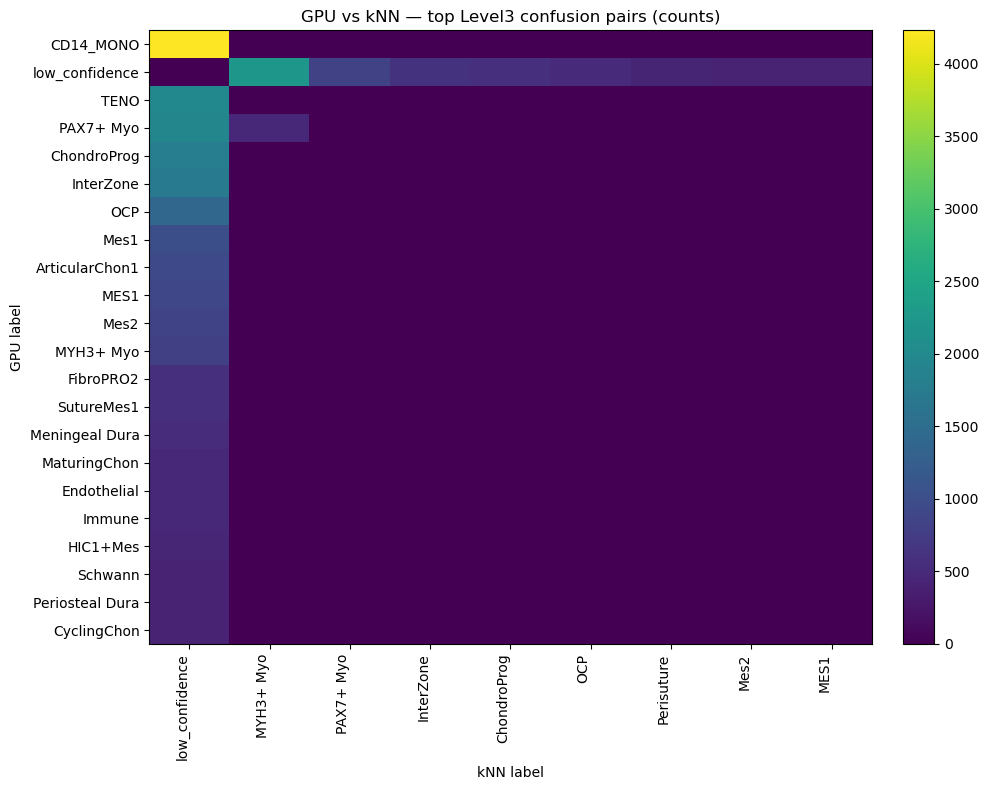

In [26]:
import numpy as np
import matplotlib.pyplot as plt

top_pairs = pair_counts.head(30)   # choose N
pivot = top_pairs.pivot(index="gpu_L3", columns="knn_L3", values="n").fillna(0)

plt.figure(figsize=(10, 8))
im = plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=90, ha="right")
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.xlabel("kNN label")     # <-- columns
plt.ylabel("GPU label")     # <-- rows
plt.title("GPU vs kNN — top Level3 confusion pairs (counts)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


In [27]:
mismatched_cells= adata_full[adata_full.obs_names.isin(mismatch['Cell_ID'])].copy()

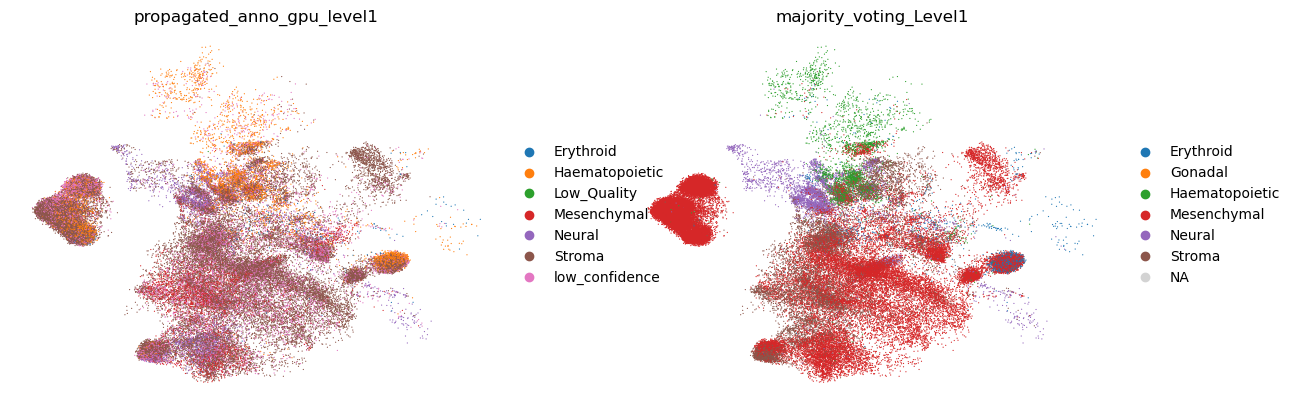

In [28]:
sc.pl.umap(
    mismatched_cells, 
    color=['propagated_anno_gpu_level1', 'majority_voting_Level1'],
    size=3,               # Increase point size for better visibility
    legend_loc='right margin',  # Or 'right margin' if you want a separate legend
    frameon=False,
 
              # High resolution
)


In [29]:
mismatched_cells

AnnData object with n_obs × n_vars = 61532 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels_unfiltered', 'over_clustering_unfiltered', 'majority_voting_unfiltered', 'predicted_labels_Level1_unfiltered', 'predicted_labels_Level2_unfiltered', 'majority_voting_Level1_unfiltered', 'majority_voting_Level2_unfiltered', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predi

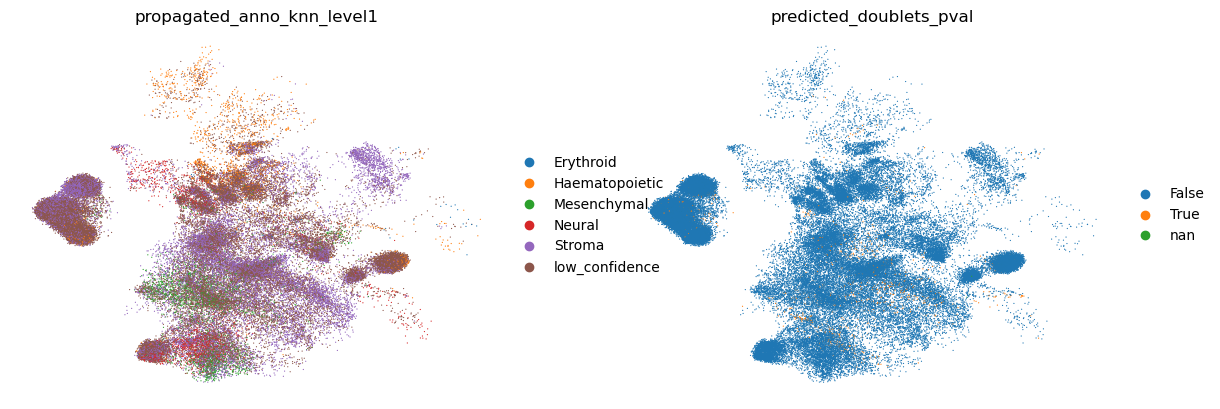

In [30]:
sc.pl.umap(
    mismatched_cells, 
    color=['propagated_anno_knn_level1', 'predicted_doublets_pval'],
    size=3,               # Increase point size for better visibility
    legend_loc='right margin',  # Or 'right margin' if you want a separate legend
    frameon=False,
 
              # High resolution
)


In [31]:
mismatched_cells.obs['propagated_anno_knn_level1'].value_counts()

propagated_anno_knn_level1
low_confidence    33667
Stroma            21615
Mesenchymal        2693
Haematopoietic     1767
Neural             1738
Erythroid            52
Name: count, dtype: int64

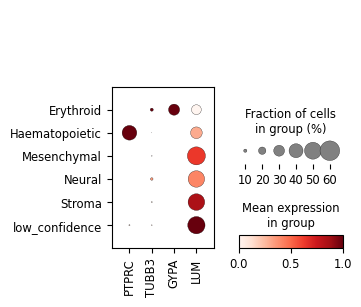

In [31]:
sc.pl.dotplot(
    mismatched_cells,
    var_names=["PTPRC","TUBB3","GYPA","LUM"],           # note: gene may be called TNFSF11 in your matrix
    groupby="propagated_anno_knn_level1",
    standard_scale="var",
    dot_min=0.05, dot_max=0.6,
    swap_axes=False
)


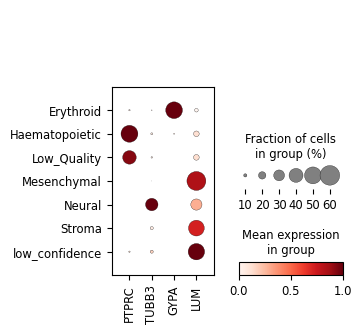

In [32]:
sc.pl.dotplot(
    adata_full,
    var_names=["PTPRC","TUBB3","GYPA","LUM"],           # note: gene may be called TNFSF11 in your matrix
    groupby="propagated_anno_gpu_level1",
    standard_scale="var",
    dot_min=0.05, dot_max=0.6,
    swap_axes=False
)


In [32]:
adata_full.obs['propagated_anno_knn_level1'].value_counts()

propagated_anno_knn_level1
Stroma            892989
Haematopoietic    232411
low_confidence    190535
Mesenchymal       117766
Neural            109276
Erythroid          23378
Low_Quality          513
Name: count, dtype: int64

In [33]:
adata_full.obs['propagated_anno_gpu_level1'].value_counts()

propagated_anno_gpu_level1
Stroma            905701
Haematopoietic    237682
low_confidence    170388
Mesenchymal       119086
Neural            109875
Erythroid          23620
Low_Quality          516
Name: count, dtype: int64

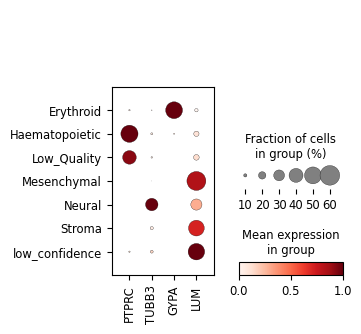

In [34]:
sc.pl.dotplot(
    adata_full,
    var_names=["PTPRC","TUBB3","GYPA","LUM"],           # note: gene may be called TNFSF11 in your matrix
    groupby="propagated_anno_knn_level1",
    standard_scale="var",
    dot_min=0.05, dot_max=0.6,
    swap_axes=False
)


In [35]:
# ================= SAVE / LOAD / REPLACE obs =================
import os
import pandas as pd

def save_obs(adata, out_path):
    """
    Save adata.obs (plus obs_names) to one file.
    - If extension omitted, writes .parquet (falls back to .csv.gz if Parquet unavailable).
    Returns the actual path written.
    """
    df = adata.obs.copy()
    df.insert(0, "obs_name", adata.obs_names.astype(str).to_numpy())
    root, ext = os.path.splitext(out_path)

    # Choose format
    try:
        if ext.lower() == ".parquet" or ext == "":
            out_file = root + ".parquet" if ext == "" else out_path
            df.to_parquet(out_file, compression="zstd")
            return out_file
    except Exception:
        pass

    # Fallback: CSV.gz
    out_file = (root if ext == "" else root) + ".csv.gz"
    df.to_csv(out_file, index=False)
    return out_file

def load_obs(path):
    """Load an obs file saved by save_obs(); returns DataFrame indexed by obs_name."""
    if path.endswith(".parquet"):
        df = pd.read_parquet(path)
    else:
        df = pd.read_csv(path)
    if "obs_name" not in df.columns:
        raise KeyError("Expected 'obs_name' column.")
    return df.set_index("obs_name")

def replace_obs(adata, new_obs_df, strict=True):
    """
    Replace adata.obs entirely with new_obs_df (aligned by obs_names).
    - strict=True: require exact one-to-one coverage of all cells; raise if mismatch.
    """
    idx_ad   = pd.Index(adata.obs_names.astype(str))
    idx_new  = pd.Index(new_obs_df.index.astype(str))
    missing  = idx_ad.difference(idx_new)
    extras   = idx_new.difference(idx_ad)

    if strict and (len(missing) or len(extras)):
        raise ValueError(
            f"Index mismatch: missing {len(missing)} obs_names in new_obs, "
            f"and {len(extras)} extra not in AnnData."
        )

    # Align order; drop extras if not strict, fill NaNs for missing rows
    new_aligned = new_obs_df.reindex(idx_ad)
    adata.obs = new_aligned  # <- REPLACE (not merge)
    print(f"[replace_obs] adata.obs replaced with {new_aligned.shape[1]} cols for {adata.n_obs} rows.")

# ---------------- Convenience for both objects ----------------
def save_obs_pair(adata_full, adata, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    f1 = save_obs(adata_full, os.path.join(out_dir, "bone_atlas_adata_full.obs"))
    f2 = save_obs(adata,      os.path.join(out_dir, "bone_atlas_adata_hvg.obs"))
    print(f"[saved]\n  {f1}\n  {f2}")
    return f1, f2

def load_obs_pair(out_dir):
    # Prefer Parquet; fallback to CSV.gz
    f1 = os.path.join(out_dir, "adata_full.obs.parquet")
    f2 = os.path.join(out_dir, "adata.obs.parquet")
    if not os.path.exists(f1): f1 = os.path.join(out_dir, "adata_full.obs.csv.gz")
    if not os.path.exists(f2): f2 = os.path.join(out_dir, "adata.obs.csv.gz")
    return load_obs(f1), load_obs(f2)

def restore_obs_pair_replace(adata_full, adata, out_dir, strict=True):
    obs_full, obs_hvg = load_obs_pair(out_dir)
    replace_obs(adata_full, obs_full, strict=strict)
    replace_obs(adata,      obs_hvg,  strict=strict)
# ==============================================================


In [35]:
save_obs_pair(adata_full, adata, "/nfs/team298/sm54/BoneAtlasProject/metadata/cell_metadata/")


[saved]
  /nfs/team298/sm54/BoneAtlasProject/metadata/cell_metadata/bone_atlas_adata_full.csv.gz
  /nfs/team298/sm54/BoneAtlasProject/metadata/cell_metadata/bone_atlas_adata_hvg.csv.gz


('/nfs/team298/sm54/BoneAtlasProject/metadata/cell_metadata/bone_atlas_adata_full.csv.gz',
 '/nfs/team298/sm54/BoneAtlasProject/metadata/cell_metadata/bone_atlas_adata_hvg.csv.gz')

In [ ]:
# Save (choose your filenames)
save_obs(adata_full, "/nfs/team298/sm54/BoneAtlasProject/cell_metadata/bone_atlas_adata_full.obs.parquet")
save_obs(adata,      "/nfs/team298/sm54/BoneAtlasProject/cell_metadata/bone_atlas_adata_hvg.obs.parquet")


In [56]:
from PIL import Image
import matplotlib.pyplot as plt

in_path  = "/nfs/team298/sm54/BoneAtlasProject/src/annotation/figures/KNN_Label_Propagation.png"
out_path = "/nfs/team298/sm54/BoneAtlasProject/src/annotation/figures/KNN_Label_Propagation_annotated.png"

img = Image.open(in_path)
w, h = img.size
fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=300)
ax.imshow(img); ax.axis("off")

def xy(px, py):      # data coords (pixels)
    return (px*w, py*h)

# --- d_i label: slightly above the line & a bit left ---
di_annot = ax.annotate(
    r"$d_i = \| \mathbf{q} - \mathbf{r}_i \|_2$",
    xy=xy(0.205, 0.475),           # anchor near the arrow head
    xytext=xy(0.160, 0.38),       # ↑ smaller y = higher; smaller x = left
    fontsize=32,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9),
    clip_on=False
)

# --- Big formula box: centered-ish and lower, using axes-fraction coords ---
# (0,0) is bottom-left of axes; (1,1) is top-right
big_text = ax.text(
    0.50, 0.35,                     # x=center-ish, y=lower than mid
    (
        r"Distance-weighted vote:" "\n\n"
        r"$w_i = \frac{1}{d_i + \varepsilon}$" "\n\n"
        r"$W_c = \sum_{i:\,\mathrm{label}(r_i)=c} w_i$" "\n\n"
        r"Predicted label $= \arg\max_c W_c$" "\n\n"
        r"Confidence $= \dfrac{\max_c W_c}{\sum_{c'} W_{c'}}$"
    ),
    transform=ax.transAxes,         # <<< axes-fraction positioning
    fontsize=32, va="top", ha="center",
    bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", alpha=0.5),
    clip_on=False
)

# Give a tiny margin so nothing hugs the edge
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)

# Ensure tight bbox includes the annotation boxes
plt.savefig(
    out_path,
    bbox_inches="tight",
    pad_inches=0.5,
    bbox_extra_artists=[di_annot, big_text]
)
print("Saved:", out_path)


Saved: /nfs/team298/sm54/BoneAtlasProject/src/annotation/figures/KNN_Label_Propagation_annotated.png
